# Prueba Técnica – NLP + Chatbot + Dashboard

## 0. Setup

In [1]:
# !pip install pandas scikit-learn sentence-transformers rapidfuzz pypdf numpy fastapi uvicorn[standard] python-multipart
import pandas as pd, numpy as np
from pathlib import Path
DATA = Path('data')
DOCS = Path('docs')
list(DOCS.glob('*.pdf')), list(DATA.glob('*.csv')) 


([WindowsPath('docs/doc1_politica_gobierno_datos.pdf'),
  WindowsPath('docs/doc2_procedimiento_atencion_usuarios.pdf'),
  WindowsPath('docs/doc3_reporte_trimestral_operacion.pdf'),
  WindowsPath('docs/doc4_manual_terminos_servicio.pdf'),
  WindowsPath('docs/doc5_preguntas_frecuentes_internas.pdf')],
 [WindowsPath('data/faqs_test.csv'), WindowsPath('data/faqs_train.csv')])

## 1. PDFs → Texto

Pre-procesamiento de textos: Limpieza básica

In [2]:
from pypdf import PdfReader
import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r'\s+', ' ', text)  # normaliza espacios y saltos de linea    
    text = re.sub(r'[^a-záéíóúüñ0-9.,:;?! ]', '', text) # elimina caracteres especiales, conserva letras, números y puntuación básica
    return text.strip()

def read_pdf(path):
    text = []
    r = PdfReader(str(path))
    for p in r.pages:
       page_text = p.extract_text() or ""
       text.append(clean_text(page_text))
    return "\n".join(text)
corpus = {p.name: read_pdf(p) for p in DOCS.glob('*.pdf')}
list(corpus.keys())

['doc1_politica_gobierno_datos.pdf',
 'doc2_procedimiento_atencion_usuarios.pdf',
 'doc3_reporte_trimestral_operacion.pdf',
 'doc4_manual_terminos_servicio.pdf',
 'doc5_preguntas_frecuentes_internas.pdf']

In [3]:
# Visualizar contenido de un PDF X
name, text = list(corpus.items())[1]
print("PDF:", name)
print("Contenido:", text)

PDF: doc2_procedimiento_atencion_usuarios.pdf
Contenido: doc2 procedimiento atencion usuarios contenido de referencia para la prueba.


EDA (exploratory data analysis) con WordCloud

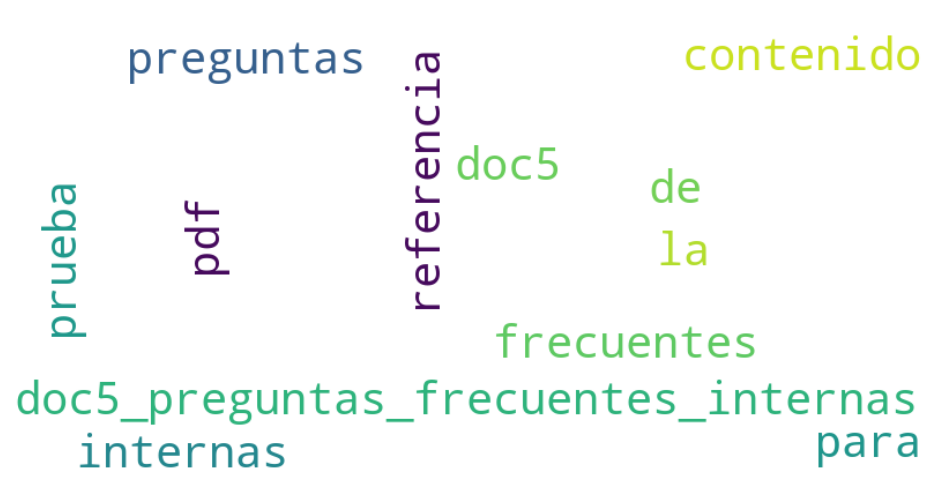

In [4]:
# Visualizar las palabras más frecuentes en el documento doc5_preguntas_frecuentes_internas.pdf.
# Da una idea general del contenido de los documentos.
# Por ejemplo, en X documento, donde se mencione repetidamente "mala atención", podemos identificar los tópicos que interesan a los usuarios y donde poder tomar acciones estratégica.
# Se pues aplicar con bigramas, trigramas etc, para contextualizar más. Además de un analisis por documentos similares.

from wordcloud import WordCloud
import matplotlib.pyplot as plt

# concatenar todo el texto de los PDFs
all_text = " ".join(list(corpus.items())[-1])

# generar la nube
wc = WordCloud(width=800, height=400, background_color="white",
               collocations=False).generate(all_text)

# mostrarla
plt.figure(figsize=(12,6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()


## 2. Tópicos / Embeddings

Generación de embeddings de cada documento

In [21]:
# TODO: Implementar LDA o embeddings + clustering y exportar a JSON/CSV

# Tomo la decisión de elegir 3 componentes basado en la siguientes hipótesis:
# 1. Podríamos tener tres tópicos:
#   A. Documentos legales: política de datos, términos de servicio.
#   B. Documentos de atencion: procedimiento de atención, FAQs internas.
#   C. Documentos operativo: reporte trimestral
# Una decisión más cuantitavia, sería aplicar métodos como coherence score o perplexity para validar el número óptimo de tópicos.

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords

spanish_stopwords = stopwords.words("spanish") # Stopwords en español

# 1. Vectorizar textos
vectorizer = CountVectorizer(stop_words=spanish_stopwords)
X = vectorizer.fit_transform(corpus.values()) 

# 2. LDA
n_components=3
lda = LatentDirichletAllocation(n_components=n_components, random_state=42)
lda.fit(X)

# 3. Palabras por tópico
terms = vectorizer.get_feature_names_out()
n_top_words = 10

for idx, topic in enumerate(lda.components_):
    print(f"Tópico {idx}:")
    print(" ".join([terms[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))


Tópico 0:
referencia prueba contenido preguntas frecuentes doc5 internas reporte doc3 operacion
Tópico 1:
contenido prueba referencia usuarios doc2 procedimiento atencion frecuentes internas doc5
Tópico 2:
referencia prueba contenido gobierno datos principios política métricas lineamientos interoperabilidad


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\px05202\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
# Distribución de las probabilidades de un documento pertenecer a un tópico
doc_topic_dist = lda.transform(X)

import pandas as pd
df_doc_topics = pd.DataFrame(doc_topic_dist, 
                             index=corpus.keys(), 
                             columns=[f"Tópico {i}" for i in range(n_components)])
print(df_doc_topics)

                                          Tópico 0  Tópico 1  Tópico 2
doc1_politica_gobierno_datos.pdf          0.011437  0.011325  0.977239
doc2_procedimiento_atencion_usuarios.pdf  0.042092  0.912822  0.045086
doc3_reporte_trimestral_operacion.pdf     0.042602  0.045197  0.912200
doc4_manual_terminos_servicio.pdf         0.042602  0.045197  0.912200
doc5_preguntas_frecuentes_internas.pdf    0.042602  0.045197  0.912200


1. De acuerdo con el resultado anterior, los t+opicos quedaron:
    * Tópico 1: Atención a usuarios
    * Tópico 2: EL restante de los documentos

2. Dado que los PDFs son muy breves (en algunos casos solo contienen texto de referencia para la prueba), los resultados deben tomarse como ilustrativos. Por lo tanto, con los resultados anteriores, mi hipótesis planteada queda nula.

In [20]:
# Exportar distribución de tópicos por documento
df_doc_topics.to_csv("output/resultados_topicos_por_documento.csv", index=True)

# Exportar tópicos y sus palabras clave
topics = []
for idx, topic in enumerate(lda.components_):
    top_features = [terms[i] for i in topic.argsort()[:-n_top_words:-1]]
    topics.append({
        "topic_id": idx,
        "keywords": top_features
    })

import json
with open("output/resultados_topicos.json", "w", encoding="utf-8") as f:
    json.dump(topics, f, indent=2, ensure_ascii=False)


# Resumen Ejecutivo – Análisis de Tópicos en Documentos

## Objetivo
• Leer y limpiar el texto de los PDFs.

• Identificar tópicos principales usando LDA o embeddings + clustering.

• Exportar un JSON o CSV con los tópicos y keywords por documento.


## Metodología
- Se utilizó **Latent Dirichlet Allocation (LDA)** con 3 tópicos principales.
- Se incluyeron **stopwords en español** para limpiar.
- Se generó un análisis de:
  - **Palabras clave por tópico**.
  - **Distribución de probabilidades de tópicos por documento**.
  - Exportación de resultados en **CSV y JSON** para consumo posterior.


## Hipótesis inicial
- Podríamos tener tres tópicos:
   - A. Documentos legales: política de datos, términos de servicio.
   - B. Documentos de atencion: procedimiento de atención, FAQs internas.
   - C. Documentos operativo: reporte trimestral
- Una decisión más cuantitavia, sería aplicar métodos como coherence score o perplexity para validar el número óptimo de tópicos.

## Hallazgos Clave

**Tópico 0**: Cero documentos

**Tópico 1**: Documento de: Atención a usuarios

**Tópico 2**: EL restante de los documentos

**Conclusión**:La hipótesis inicial de tres grupos con determinados tópicos no se mostró como esperaba.
Mi hipótesis planteada queda nula.
Esto se debe a que los PDFs son muy breves.

## Entregables
- **CSV**: Distribución de probabilidades de tópicos por documento.  
- **JSON**: Lista de tópicos con palabras clave.  


## 3. Chatbot (Clasificador o RAG)

Carga de datos

In [12]:
# TODO: Entrenar y exponer función responder(pregunta)

import pandas as pd

train = pd.read_csv(DATA / "faqs_train.csv")
test = pd.read_csv(DATA / "faqs_test.csv")

train.head()

,question,answer
0,¿Cómo descargo mi certificado?,Ingresa al Portal > Mi Perfil > Certificados y...
1,¿Dónde veo el estado de mi trámite?,Ingresa al Portal > Mis trámites > Estado para...
2,"Olvidé mi contraseña, ¿qué hago?",Usa la opción '¿Olvidaste la contraseña?' en l...
3,¿En cuánto tiempo responden una PQRS?,El SLA objetivo es 24 horas hábiles según el p...
4,¿Cómo actualizo mis datos personales?,Ve a Portal > Configuración > Datos personales...


In [13]:
test.head()

,question,expected_contains
0,¿Cómo genero un certificado para descargar?,Mi Perfil > Certificados
1,¿Cuál es el tiempo promedio de respuesta?,24 horas hábiles
2,"Necesito cambiar mi dirección, ¿cómo lo hago?",Portal > Configuración > Datos personales


Vectorizar preguntas con TF-IDF

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words=spanish_stopwords)
X_train = vectorizer.fit_transform(train["question"])
X_test = vectorizer.transform(test["question"])

Entrenar modelo clasificador

In [15]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, train["answer"])

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


Función responder(pregunta)

In [16]:
def responder(pregunta: str) -> str:
    X_prueba = vectorizer.transform([pregunta])
    pred = clf.predict(X_prueba)[0]
    return pred

pregunta = "¿Cómo descargo un certificado?"
respuesta = responder(pregunta)
print(respuesta)

Ingresa al Portal > Mi Perfil > Certificados y presiona Descargar.


In [17]:
pregunta_2 = "¿Tiempo de respuesta?"
respuesta_2 = responder(pregunta_2)
print(respuesta_2)

El SLA objetivo es 24 horas hábiles según el procedimiento vigente.


In [18]:
pregunta_3 = "¿Cambio de direccion?"
respuesta_3 = responder(pregunta_3)
print(respuesta_3)

Usa la opción '¿Olvidaste la contraseña?' en la pantalla de ingreso.


Confunde direccion con contraseña, se puede refinar el modelo

## 4. Evaluación con data/faqs_test.csv

In [17]:
# TODO: comparar respuestas con 'expected_contains' (contains) y reportar accuracy

# Generar predicciones
X_test = vectorizer.transform(test["question"])
y_pred = clf.predict(X_test)

# Crear DataFrame con pregunta y predicción
df_results = pd.DataFrame({
    "question": test["question"],
    "predicted": y_pred,
    "expected_contains": test["expected_contains"]
})

# Mostrar tabla
df_results

,question,predicted,expected_contains
0,¿Cómo genero un certificado para descargar?,Ingresa al Portal > Mi Perfil > Certificados y...,Mi Perfil > Certificados
1,¿Cuál es el tiempo promedio de respuesta?,El SLA objetivo es 24 horas hábiles según el p...,24 horas hábiles
2,"Necesito cambiar mi dirección, ¿cómo lo hago?",Usa la opción '¿Olvidaste la contraseña?' en l...,Portal > Configuración > Datos personales


In [27]:
from sklearn.metrics import accuracy_score, f1_score

# VAlida que al menos una palabra clave de la respuesta esperada aparezca en el texto generado por el modelo.
y_pred_bool = df_results.apply(lambda row: str(row["expected_contains"]).lower() in str(row["predicted"]).lower(), axis=1)

# Como "etiquetas verdaderas" usamos True para cada fila
y_true = [True] * len(y_pred_bool)

# Calcular accuracy
accuracy = accuracy_score(y_true, y_pred_bool)
f1_score_ = f1_score(y_true, y_pred_bool, average="weighted")
print("Accuracy:", round(accuracy,2))
print("F1:",  round(f1_score_,2))

y_pred_bool

Accuracy: 0.67
F1: 0.8


0     True
1     True
2    False
dtype: bool

1. Accuracy = 0.67, El modelo acertó aproximadamente 2 de cada 3 preguntas
2. F1 = 0.8 significa que, de todas las veces que el chatbot da una respuesta considerada correcta, la mayoría son relevantes y completas.

Oportunidades de mejora:

1. Una alternativa interesante de vectorizar, sería usar embeddings, por ejemplo algunos de HugginFace que son open-source o algunos otros derivados de LLMs. Al tener embeddigns basados en modelos robustos, podriamos guardar un contexto semantico más profundo de los textos y por ende, mejores predicciones.
2. Usar otros modelos de clasificacion como una SVM, Árboles de decisión o incluso redes neuronales dependiendo de la complejidad del problema.

In [29]:
import joblib

# Guardar el modelo
joblib.dump(clf, "modelos/faq_model.pkl")

# Guardar el vectorizador
joblib.dump(vectorizer, "modelos/vectorizer.pkl")

['modelos/vectorizer.pkl']

In [ ]:
# Test fastapi
# Se debe lanzar la app antes de ejecutar este script
# En la terminal, poner: uvicorn app_fastapi.main:app --reload

import requests

# URL del endpoint
url = "http://127.0.0.1:8000/chat"

# Pregunta a enviar
payload = {"question": "¿Cómo puedo descargar mi certificado?"}

# Hacer POST
response = requests.post(url, json=payload)

# Mostrar respuesta
print(response.json())

{'answer': 'Ingresa al Portal > Mi Perfil > Certificados y presiona Descargar.'}


## 5. Dashboard

In [ ]:
## TODO: Streamlit/Plotly o Power BI

# Para ejecutar la app en stremalit primero hay que lanzar el backend con: uvicorn app_fastapi.main:app --reload  
# Luego en una terminal totalmente nueva, lanzar el front con: streamlit run app.py 